<a href="https://colab.research.google.com/github/scoobiii/gdpBrazilgoal/blob/main/global_lfpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Labor Force Participation Rate and GDP per capita

Evaluating Andrew Yang's comparison of the US to Latin American countries.

## Setup

In [ ]:
!pip install wbdata
# Install latest, since Colab is just on 0.7.
!pip install seaborn --upgrade
# adjustText from GitHub to get some latest features.
!pip install https://github.com/Phlya/adjustText/archive/master.zip

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)
     \ 3.3MB 167.6MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-lbj39384/wheels/7a/56/aa/ee86b18565ad149ba3a5470b55bbc5081701fd0b57141ed055
Successfully built adjustText


In [ ]:
import wbdata
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
from adjustText import adjust_text

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Chart options

In [ ]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2019-03-06 20:32:19--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2019-03-06 20:32:19--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf.1’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.02s   

2019-03-06 20:32:

Try https://stackoverflow.com/questions/34693991/repel-annotations-in-matplotlib

In [ ]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

## Load data

In [ ]:
indicators = {'SP.DYN.LE00.IN': 'life_expectancy',
              'SL.TLF.CACT.ZS': 'lfpr',
              'SL.TLF.ACTI.ZS': 'lfpr1564',
              'NY.GDP.PCAP.PP.CD': 'gdppcppp',
              'SP.POP.TOTL': 'pop'}
wbdf = wbdata.get_dataframe(indicators).reset_index()

Remove aggregates.

In [ ]:
geos = pd.Series(wbdf.country.unique())
world_index = geos[geos == 'World'].index[0]
aggs = geos[:world_index+1]
wbdf = wbdf[~wbdf.country.isin(aggs)]
wbdf.head()

,country,date,gdppcppp,lfpr,lfpr1564,life_expectancy,pop
2773,Afghanistan,2018,NaN,54.242001,55.750000,NaN,NaN
2774,Afghanistan,2017,1972.178018,54.237999,55.742001,NaN,35530081.0
2775,Afghanistan,2016,1934.616840,54.234001,55.731998,63.673,34656032.0
2776,Afghanistan,2015,1918.938459,53.907001,55.375999,63.288,33736494.0
2777,Afghanistan,2014,1927.087320,53.382999,54.820000,62.895,32758020.0


Add year.

In [ ]:
wbdf['year'] = wbdf.date.astype(int)
wbdf.drop('date', inplace=True, axis=1)

Determine the latest year for each indicator.

In [ ]:
def latest_year(col):
    return wbdf[~wbdf[col].isnull()].year.max()

INDICATORS = ['gdppcppp', 'lfpr', 'lfpr1564', 'life_expectancy', 'pop']

latest_years = pd.DataFrame({
    'indicator': INDICATORS,
    'latest_year': [latest_year(i) for i in INDICATORS]
})

latest_years

,indicator,latest_year
0,gdppcppp,2017
1,lfpr,2018
2,lfpr1564,2018
3,life_expectancy,2016
4,pop,2017


In [ ]:
country = pd.DataFrame({'country': wbdf.country.unique()})

for i in INDICATORS:
    tmp = wbdf[wbdf.year == latest_year(i)][['country', i]]
    country = country.merge(tmp, on='country')
    
country.dropna(inplace=True)
country.reset_index(inplace=True)

In [ ]:
TARGET_COUNTRIES = ['United States', 'Ecuador', 'Costa Rica', 'El Salvador',
                    'Dominican Republic']
country['is_target'] = country.country.isin(TARGET_COUNTRIES)

In [ ]:
country['lfpr_rank'] = country.lfpr.rank()
country['lfpr_pr'] = country.lfpr_rank / country.shape[0]
country['lfpr1564_rank'] = country.lfpr1564.rank()
country['lfpr1564_pr'] = country.lfpr1564_rank / country.shape[0]
country['font_size'] = np.where(country.country == 'United States', 12, 10)

In [ ]:
country[(country.is_target)][['country', 'life_expectancy']]

,country,life_expectancy
38,Costa Rica,79.831000
44,Dominican Republic,73.861000
45,Ecuador,76.327000
47,El Salvador,73.512000
165,United States,78.690244


In [ ]:
country[(country.is_target) | (country.country.isin(['United Kingdom', 'Korea, Rep.']))][['country', 'lfpr', 'lfpr_pr']]

,country,lfpr,lfpr_pr
38,Costa Rica,59.647999,0.385057
44,Dominican Republic,66.688004,0.655172
45,Ecuador,67.983002,0.706897
47,El Salvador,61.716000,0.465517
82,"Korea, Rep.",62.618000,0.511494
164,United Kingdom,62.340000,0.488506
165,United States,61.620998,0.459770


In [ ]:
PALETTE = {True: '#1565c0', False: '#bdbdbd'}
ALPHAS = {True: 1.0, False: 0.7}

In [ ]:
def translate_size(min_x, max_x, min_y, max_y, val):
    return min_y + (val - min_x) * (max_y - min_y) / (max_x - min_x)

In [ ]:
MIN_SIZE, MAX_SIZE = 20, 1000
min_size_target = translate_size(
    country[~country.is_target]['pop'].min(),
    country[~country.is_target]['pop'].max(),
    MIN_SIZE, MAX_SIZE,
    country[country.is_target]['pop'].min())
max_size_target = translate_size(
    country[~country.is_target]['pop'].min(),
    country[~country.is_target]['pop'].max(),
    MIN_SIZE, MAX_SIZE,
    country[country.is_target]['pop'].max())

min_size = {True: min_size_target, False: MIN_SIZE}
max_size = {True: max_size_target, False: MAX_SIZE}

In [ ]:
LABELS = {'lfpr': 'labor force participation rate, aged 15+',
          'lfpr1564': 'labor force participation rate, aged 15-64',
          'life_expectancy': 'life expectancy',
          'gdppcppp': 'GDP per capita, PPP'}

In [ ]:
TITLE_LABELS = {'lfpr': 'Labor force participation rate, aged 15+',
                'lfpr1564': 'Labor force participation rate, aged 15-64',
                'life_expectancy': 'Life expectancy',
                'gdppcppp': 'GDP per capita, PPP'}

In [ ]:
def scatter(x, y, is_target):
    return sns.scatterplot(x=x, y=y, size='pop', color=PALETTE[is_target],
                           sizes=(min_size[is_target], max_size[is_target]),
                           data=country[country.is_target == is_target],
                           alpha=ALPHAS[is_target])

In [ ]:
def chart(x, y, label=True):
    # This doesn't totally work because of the gray points.
    ax = scatter(x, y, False)
    scatter(x, y, True)
    
    if label:
        texts = [plt.text(row[x], row[y], row.country,#, size=row.font_size,
                          color=PALETTE[True])
                 for index, row in country[country.is_target].iterrows()]
        adjust_text(texts,
                    add_objects=ax.get_children()[0],
                    arrowprops=dict(arrowstyle='->', color='red'),
                    expand_points=(1.05, 1.2), expand_text=(1.05, 1.2),
                    force_text=(0.01, 0.01), force_points=(0.01, 0.01),
                    force_objects=(0.01, 0.01))
        ax.text(country[x].max(), country[y].min(), '@MaxGhenis',
            horizontalalignment='right', size=8, color=PALETTE[False])

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))

    if y == 'gdppcppp':
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
        
    if (y == 'lfpr') or (y == 'lfpr1564'):
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))
    
    ax.set(xlabel=TITLE_LABELS[x] + ' (' + str(latest_year(x)) + ')',
           ylabel=TITLE_LABELS[y] + ' (' + str(latest_year(y)) + ')')

    plt.title(TITLE_LABELS[x] + ' vs. ' + LABELS[y],
              loc='left')

    ax.grid(color='#f5f5f5')

    sns.despine(left=True, bottom=True)
    ax.get_legend().remove()
    plt.show()

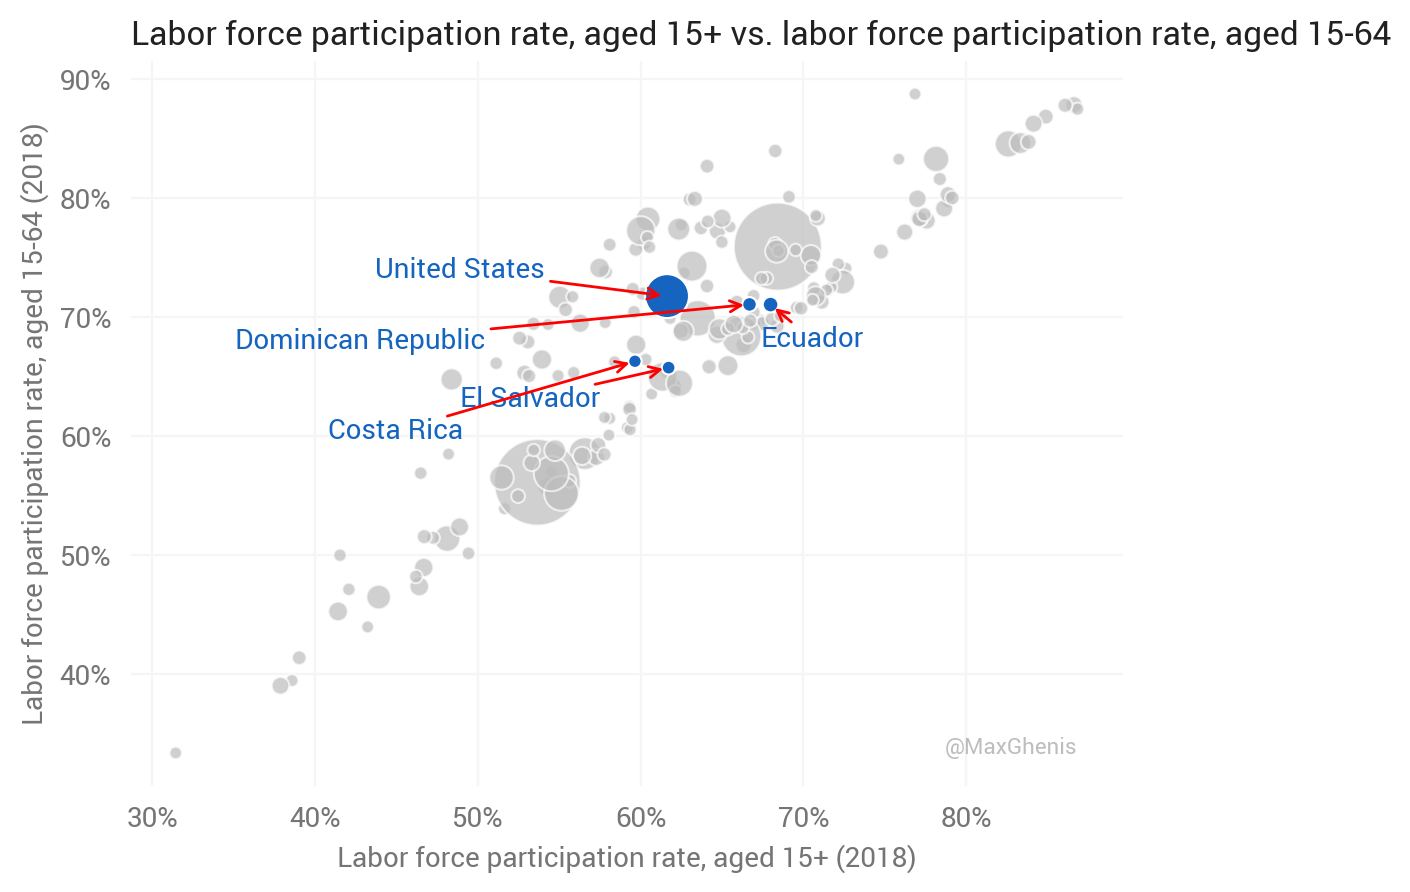

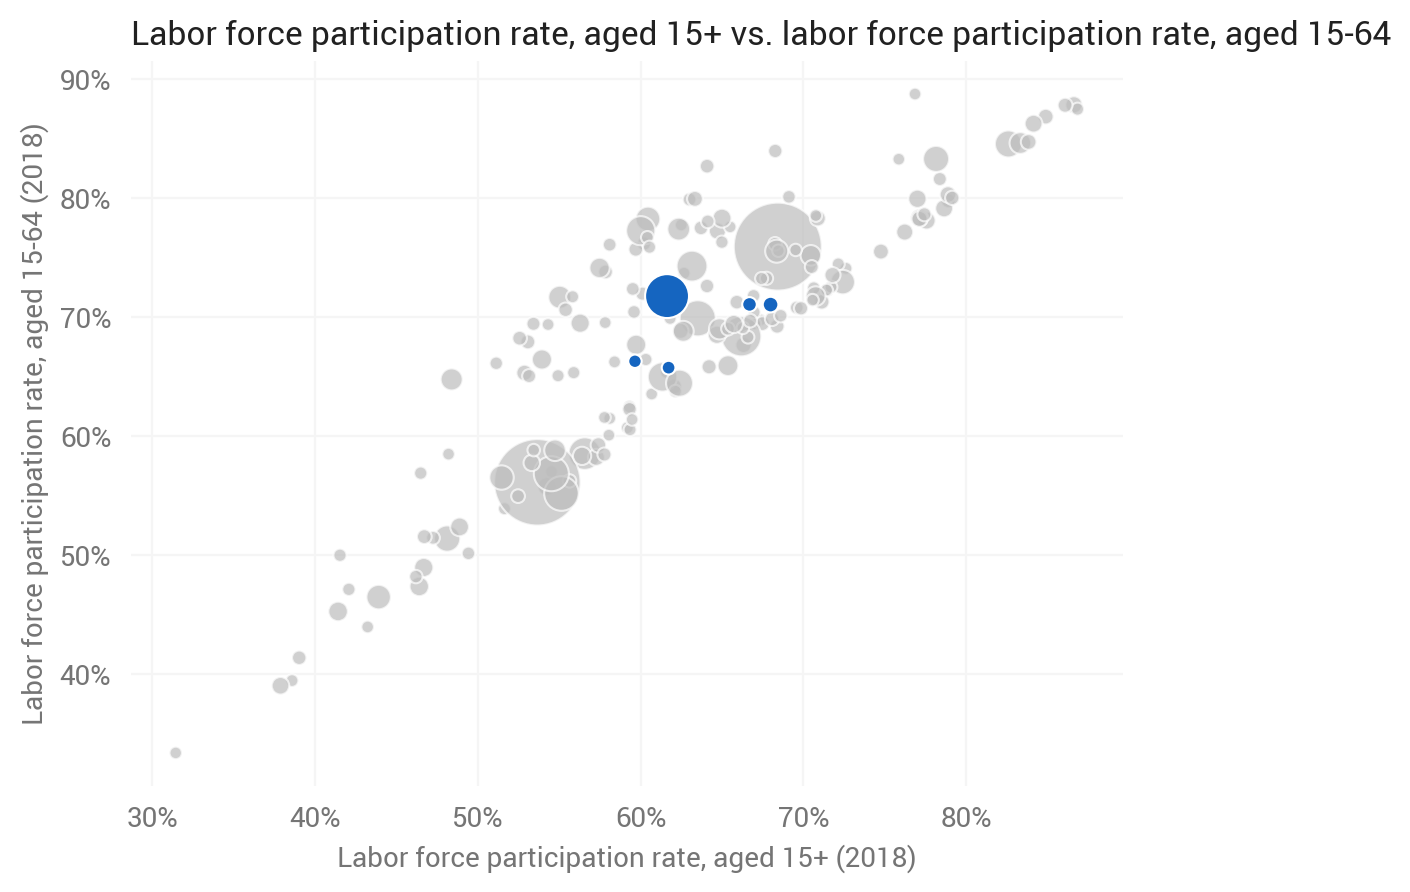

In [ ]:
chart('lfpr', 'lfpr1564', True)
chart('lfpr', 'lfpr1564', False)

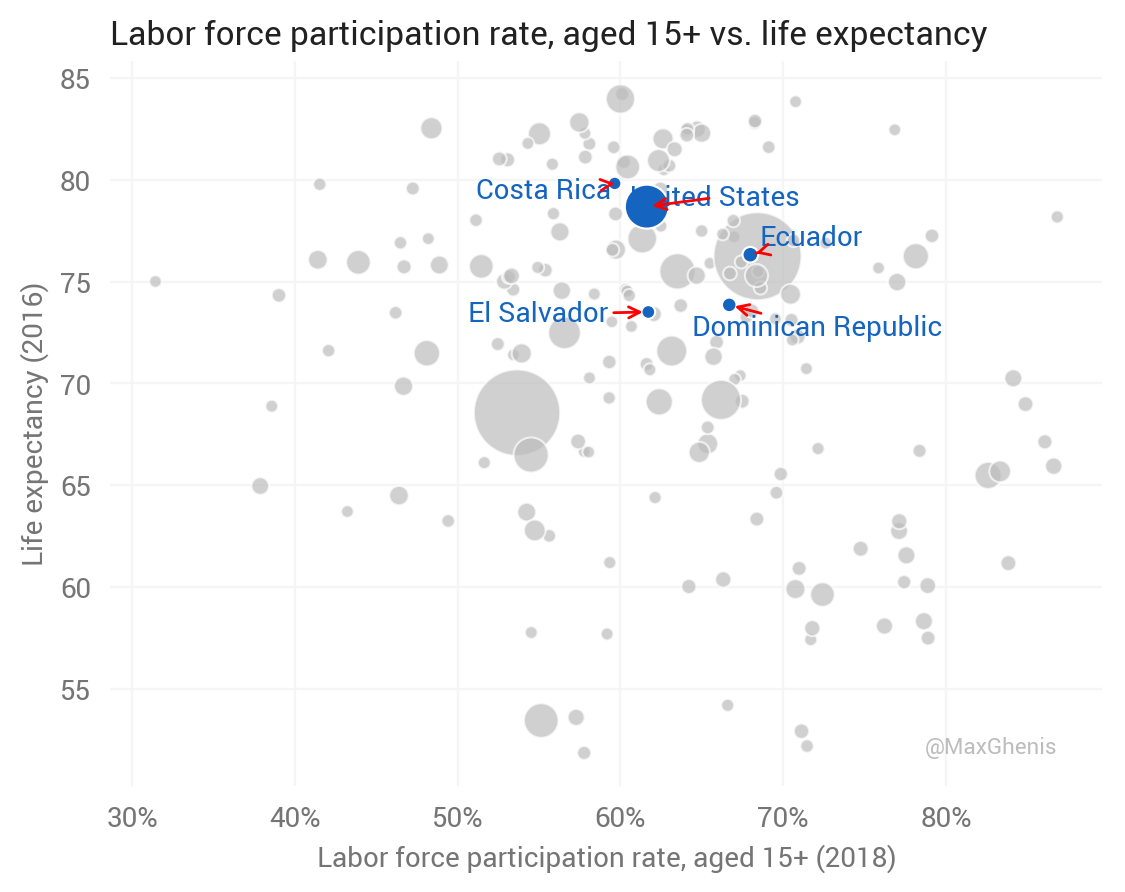

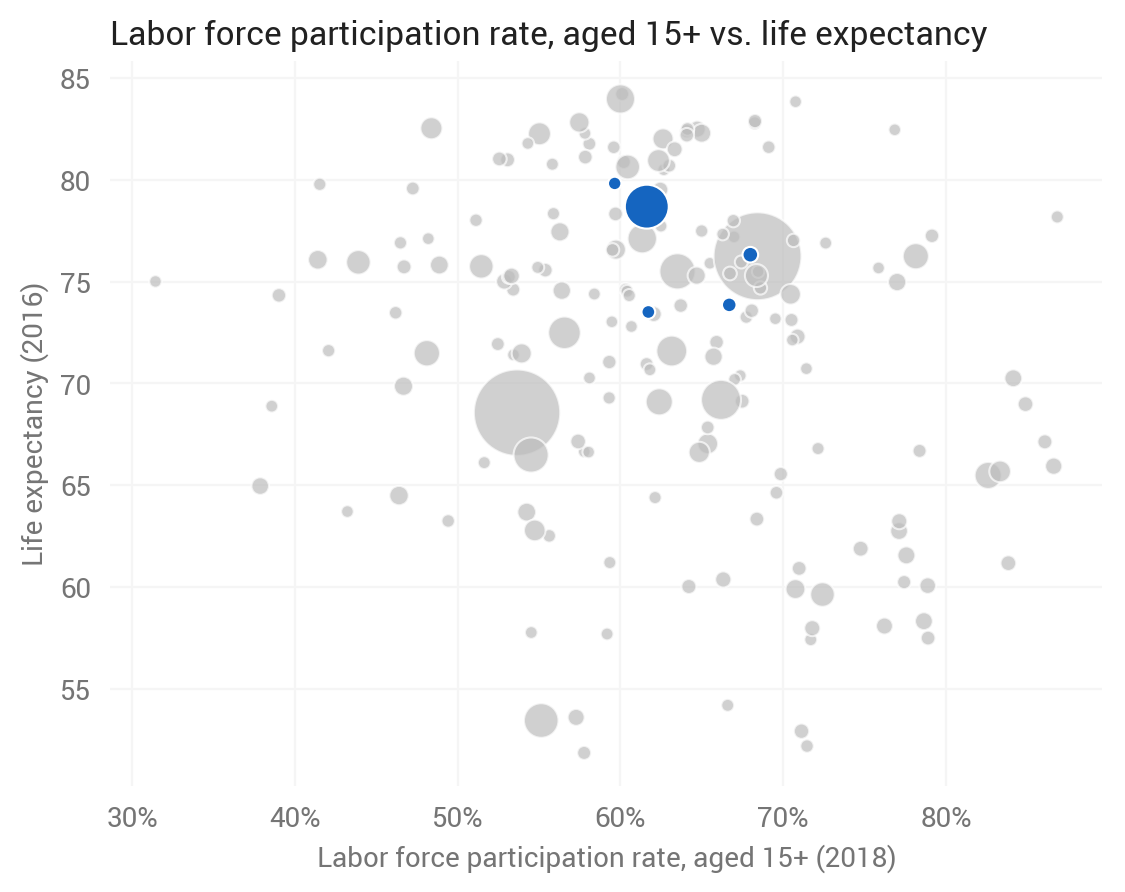

In [ ]:
chart('lfpr', 'life_expectancy', True)
chart('lfpr', 'life_expectancy', False)

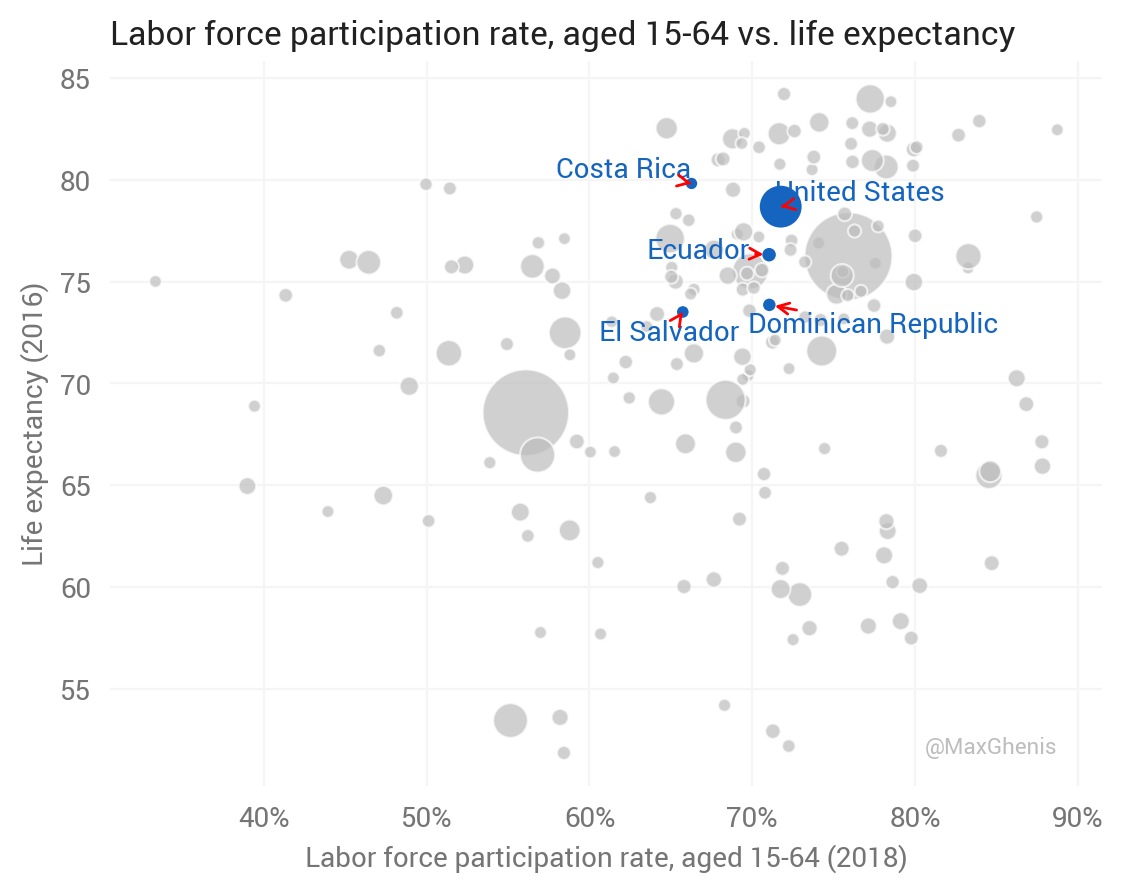

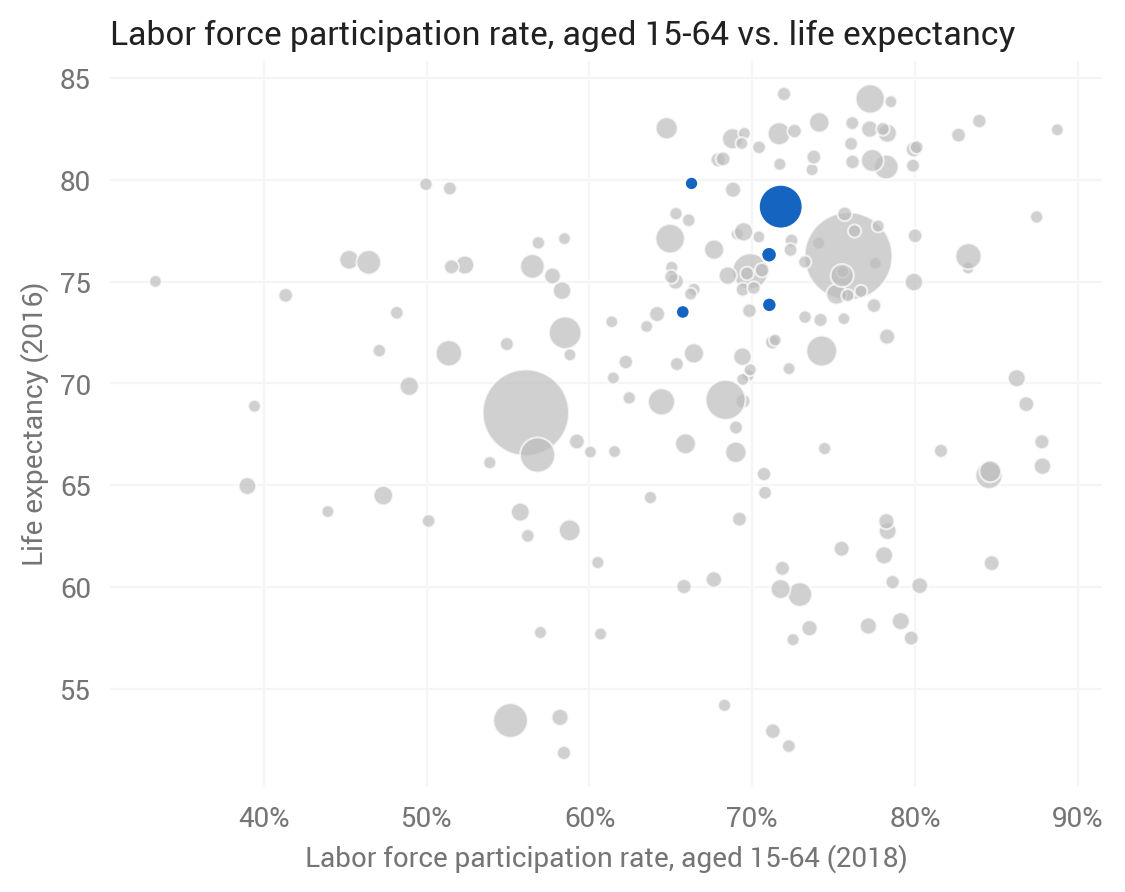

In [ ]:
chart('lfpr1564', 'life_expectancy', True)
chart('lfpr1564', 'life_expectancy', False)

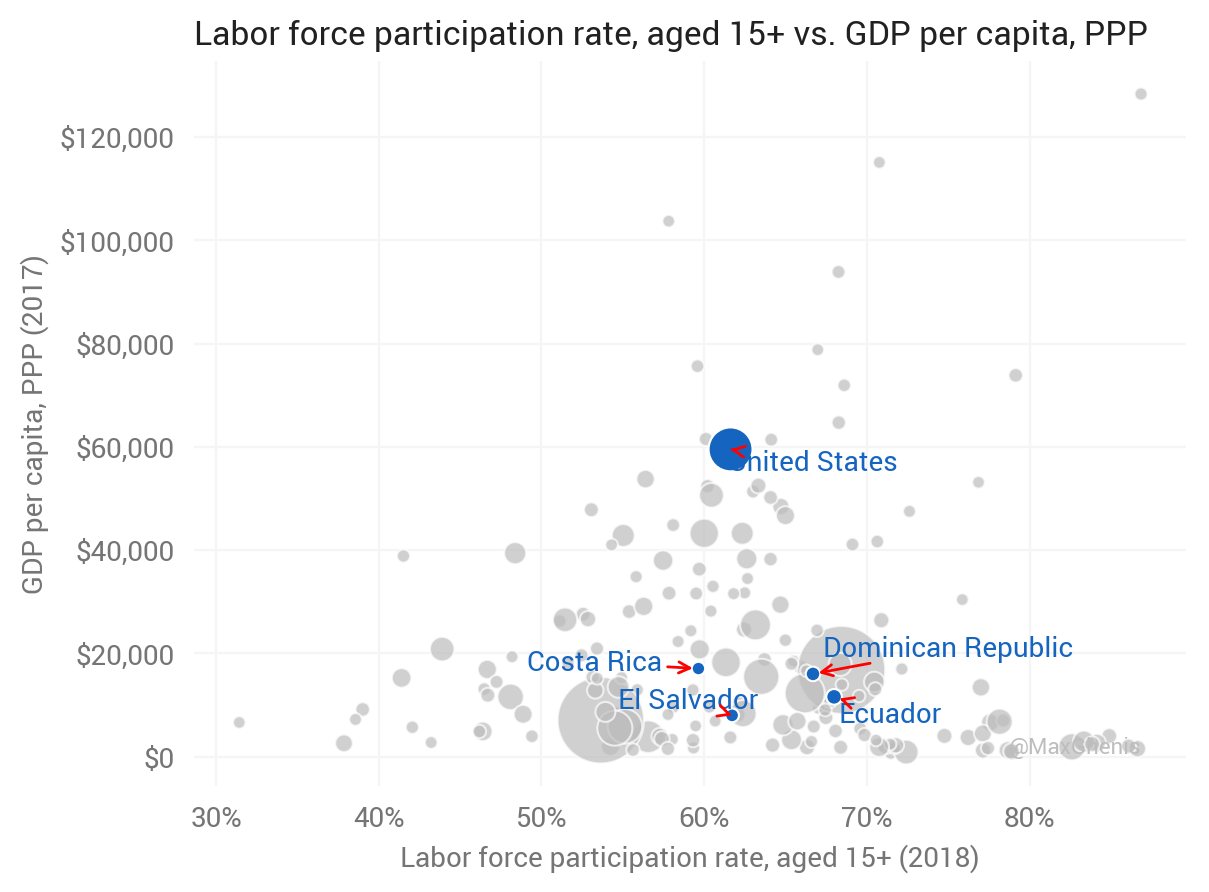

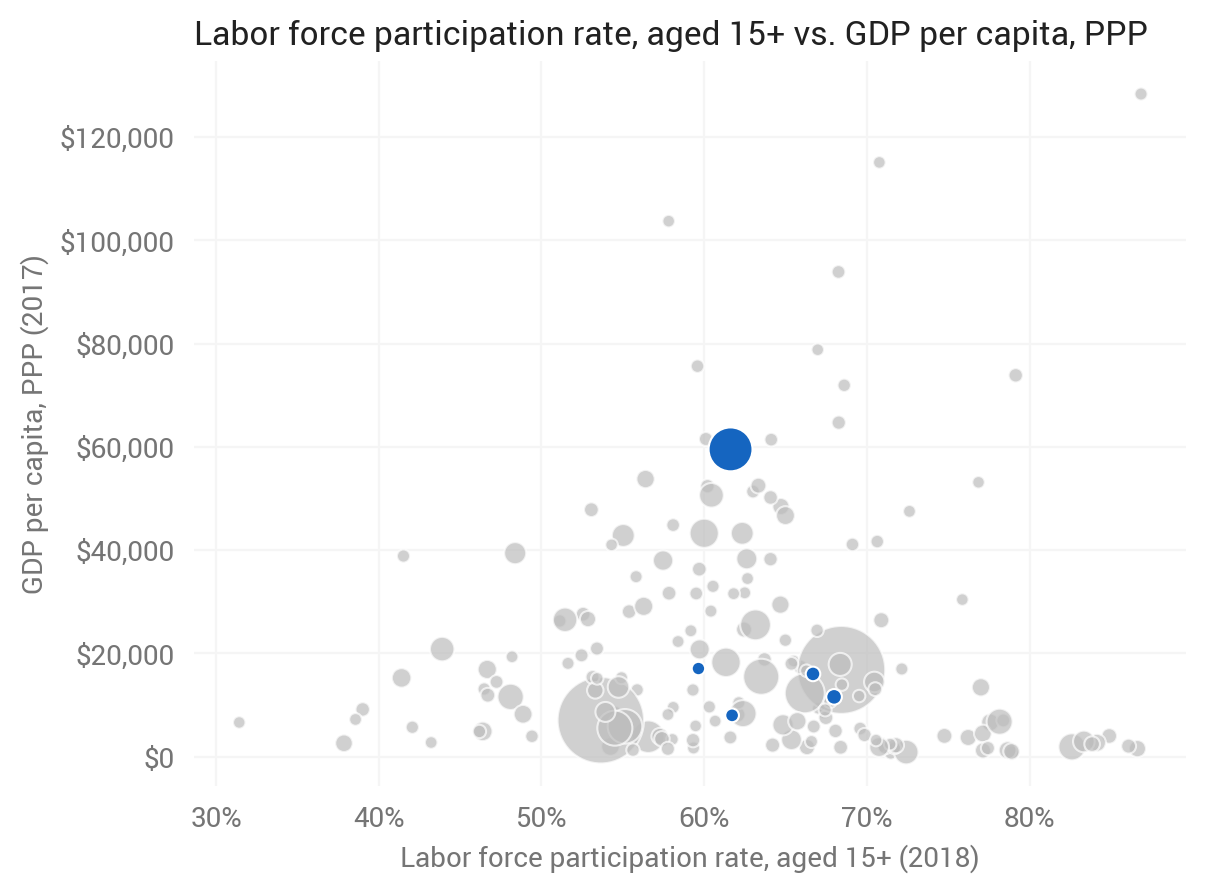

In [ ]:
chart('lfpr', 'gdppcppp', True)
chart('lfpr', 'gdppcppp', False)

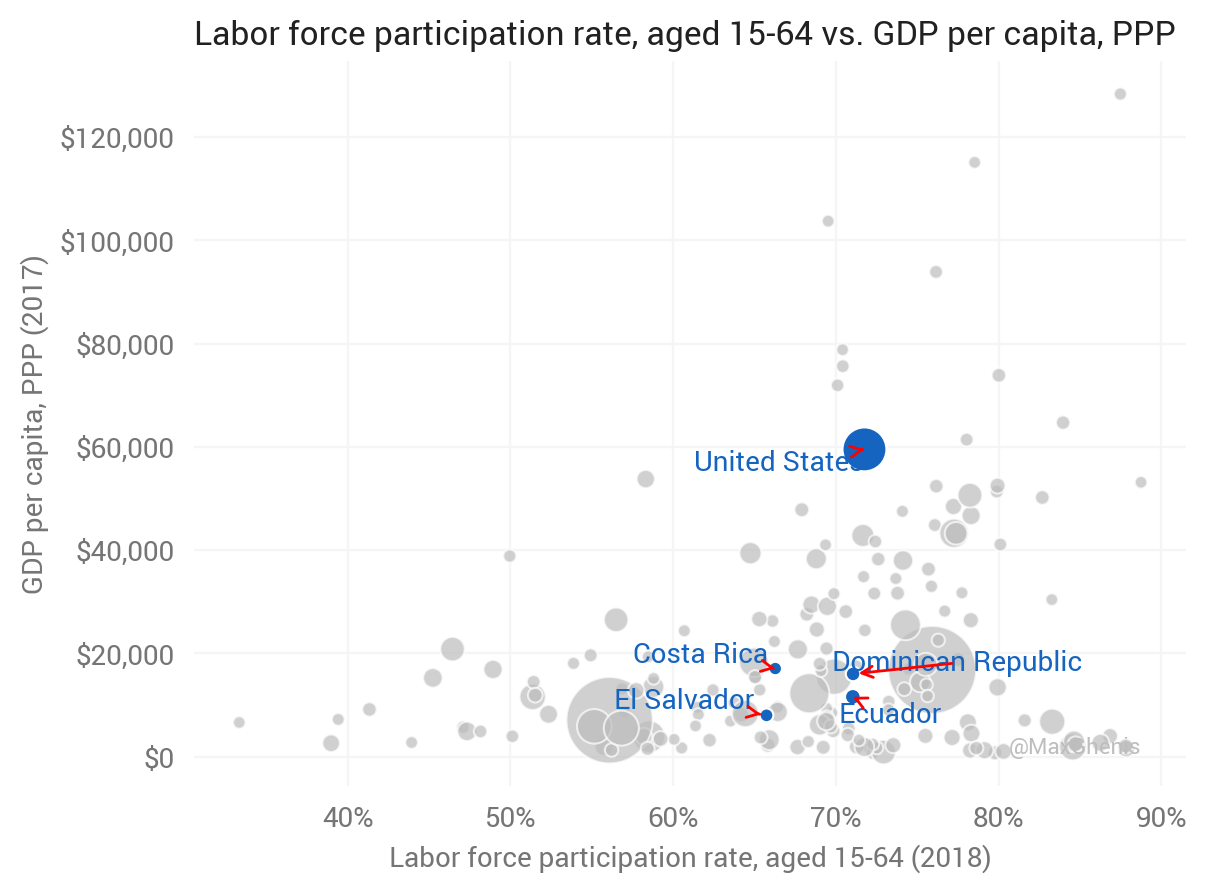

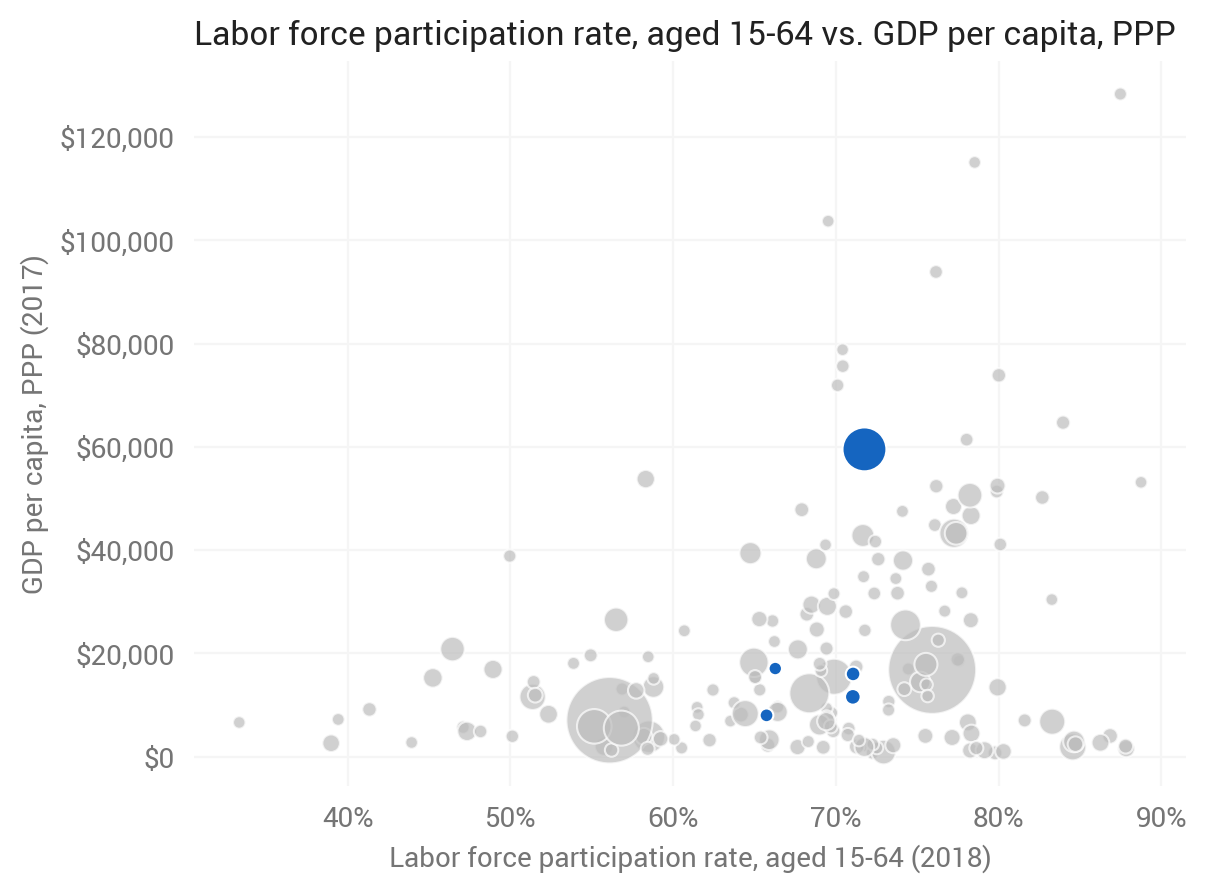

In [ ]:
chart('lfpr1564', 'gdppcppp', True)
chart('lfpr1564', 'gdppcppp', False)

## What countries have most similar LFPR to US?

In [ ]:
us = country[country.country == 'United States'].iloc[0]
country['lfpr_diff_us'] = np.abs(country.lfpr - us.lfpr)
country['lfpr1564_diff_us'] = np.abs(country.lfpr1564 - us.lfpr1564)

In [ ]:
country.sort_values('lfpr_diff_us').head(30)

,index,country,gdppcppp,lfpr,lfpr1564,life_expectancy,pop,is_target,lfpr_rank,lfpr_pr,lfpr1564_rank,lfpr1564_pr,font_size,lfpr_diff_us,lfpr1564_diff_us
165,206,United States,59531.661964,61.620998,71.750999,78.690244,325719178.0,True,80.0,0.459770,103.0,0.591954,12,0.000000,0.000000
84,107,Kyrgyz Republic,3725.541023,61.610001,65.374001,70.951220,6201500.0,False,79.0,0.454023,55.0,0.316092,10,0.010998,6.376999
47,59,El Salvador,8006.059225,61.716000,65.733002,73.512000,6377853.0,True,81.0,0.465517,56.0,0.321839,10,0.095001,6.017998
157,196,Trinidad and Tobago,31577.672999,61.810001,69.875999,70.673000,1369125.0,False,82.0,0.471264,87.0,0.500000,10,0.189003,1.875000
103,128,Mexico,18273.482183,61.341999,64.956001,77.118000,129163276.0,False,78.0,0.448276,50.0,0.287356,10,0.278999,6.794998
61,80,Guatemala,8150.253377,62.049999,64.158997,73.409000,16913503.0,False,83.0,0.477011,47.0,0.270115,10,0.429001,7.592003
110,137,Namibia,10448.705947,62.131001,63.745998,64.388000,2533794.0,False,84.0,0.482759,46.0,0.264368,10,0.510002,8.005001
164,205,United Kingdom,43268.783556,62.340000,77.384003,80.956098,66022273.0,False,85.0,0.488506,140.0,0.804598,10,0.719002,5.633003
124,155,Philippines,8342.804479,62.387001,64.427002,69.094000,104918090.0,False,86.0,0.494253,48.0,0.275862,10,0.766003,7.323997
32,40,Chile,24634.970210,62.451000,68.822998,79.522000,18054726.0,False,87.0,0.500000,72.0,0.413793,10,0.830002,2.928001


In [ ]:
country.sort_values('lfpr1564_diff_us').head(10)

,index,country,gdppcppp,lfpr,lfpr1564,life_expectancy,pop,is_target,lfpr_rank,lfpr_pr,lfpr1564_rank,lfpr1564_pr,font_size,lfpr_diff_us,lfpr1564_diff_us
165,206,United States,59531.661964,61.620998,71.750999,78.690244,325719178.0,True,80.0,0.459770,103.0,0.591954,12,0.000000,0.000000
161,202,Uganda,1864.224584,70.754997,71.747002,59.889000,42862958.0,False,140.0,0.804598,102.0,0.586207,10,9.133999,0.003998
120,151,Panama,24468.941075,66.939003,71.777000,78.001000,4098587.0,False,116.0,0.666667,104.0,0.597701,10,5.318005,0.026001
140,174,Slovenia,34868.214280,55.818001,71.697998,80.775610,2066748.0,False,44.0,0.252874,101.0,0.580460,10,5.802998,0.053001
54,68,France,42850.386280,55.028000,71.654999,82.273171,67118648.0,False,40.0,0.229885,100.0,0.574713,10,6.592999,0.096001
16,20,Benin,2271.675412,70.984001,71.858002,60.907000,11175692.0,False,143.0,0.821839,105.0,0.603448,10,9.363003,0.107002
67,86,"Hong Kong SAR, China",61540.158311,60.106998,71.956001,84.226829,7391700.0,False,71.0,0.408046,106.0,0.609195,10,1.514000,0.205002
168,209,Vanuatu,3207.831231,70.564003,71.415001,72.133000,276244.0,False,138.0,0.793103,99.0,0.568966,10,8.943005,0.335999
31,38,Chad,1941.175568,71.127998,71.271004,52.903000,14899994.0,False,144.0,0.827586,98.0,0.563218,10,9.507000,0.479996
30,37,Central African Republic,725.945420,71.468002,72.248001,52.171000,4659080.0,False,146.0,0.839080,107.0,0.614943,10,9.847004,0.497002


## Regressions

In [ ]:
country['intercept'] = 1

In [ ]:
def wls_coef(y, x):
    m = sm.WLS(country[y], country[['intercept', x]], 
               country['pop']).fit()
    return pd.DataFrame({'x': x,
                         'y': y,
                         'coef': [m.params[x]],
                         'p': [m.pvalues[x]]})    

In [ ]:
pd.concat([wls_coef('life_expectancy', 'lfpr'),
           wls_coef('life_expectancy', 'lfpr1564'),
           wls_coef('gdppcppp', 'lfpr'),
           wls_coef('gdppcppp', 'lfpr1564')
          ])[['x', 'y', 'coef', 'p']]

,x,y,coef,p
0,lfpr,life_expectancy,0.010346,0.855654
0,lfpr1564,life_expectancy,0.235874,0.000001
0,lfpr,gdppcppp,-56.439429,0.672900
0,lfpr1564,gdppcppp,476.861815,0.000034


## Changes since x

Life expectancy, 

In [ ]:
import pandas_datareader.data as web

FRED_INDS = {'MEPAINUSA672N': 'medpinc',
             'A939RX0Q048SBEA': 'gdppc',
             'SPDYNLE00INUSA': 'life'}

START_YEAR = 1990

fred = web.DataReader(FRED_INDS.keys(), 'fred', 
                      start=str(START_YEAR) + '-01-01')
fred.columns = FRED_INDS.values()
fred.dropna(inplace=True)

In [ ]:
UNEMP_INDS = {'UNRATE': 'u3',
             'U6RATE': 'u6',
             'LNS12300060': 'pa_epop',
             'LNS11300060': 'pa_lfpr'}

unemp = web.DataReader(UNEMP_INDS.keys(), 'fred', 
                       start=str(START_YEAR) + '-01-01')
unemp.columns = UNEMP_INDS.values()
unemp.dropna(inplace=True)
unemp['pa_nonemp'] = 100 - unemp.pa_epop
unemp['pa_lfnpr'] = 100 - unemp.pa_lfpr
unemp.drop(['pa_epop', 'pa_lfpr'], axis=1, inplace=True)

In [ ]:
fred_growth = fred / fred.iloc[0] - 1
fred_growth.index = fred.index.year

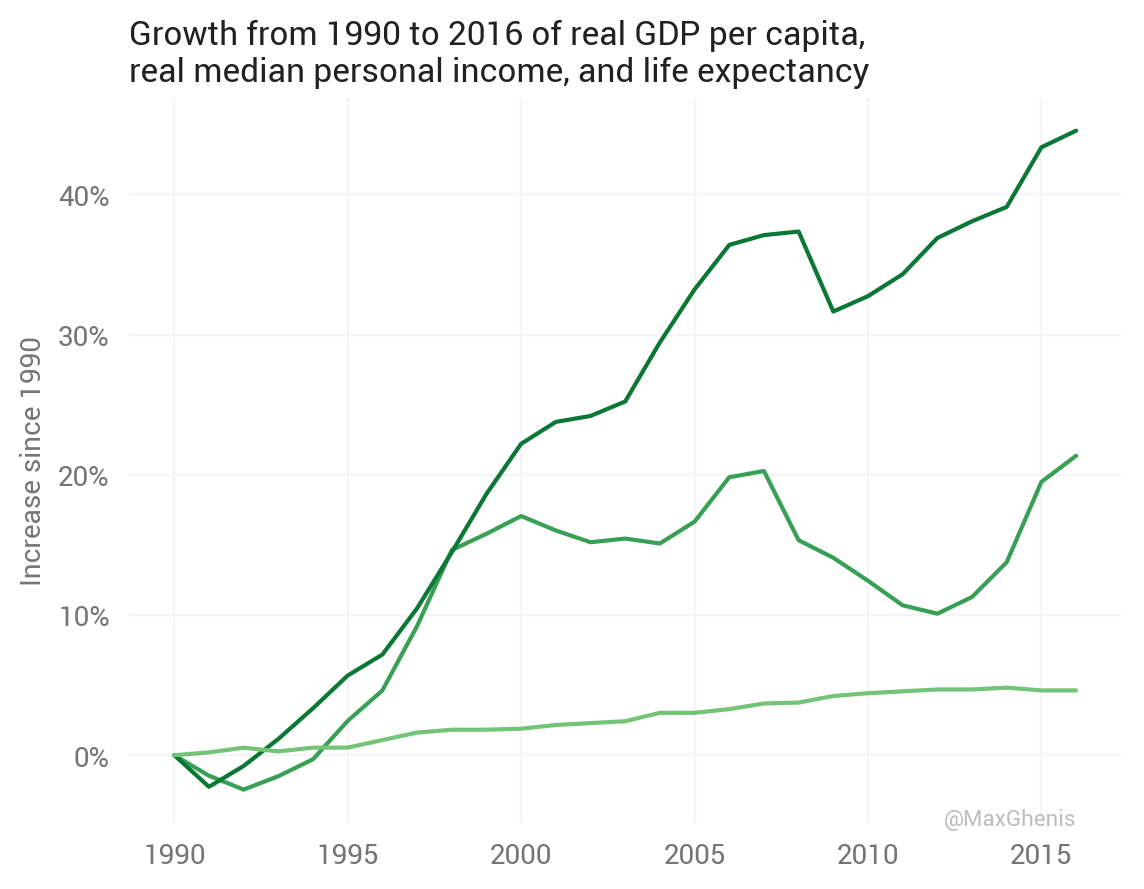

In [ ]:
# Specify order since the lines move around.
greens = sns.color_palette('Greens', 5)[2:]  # Exclude 2 lightest shades.
ax = fred_growth.plot(color=[greens[1], greens[2], greens[0]])
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ',') + '%'))

ax.set(xlabel='', 
       ylabel='Increase since ' + str(START_YEAR))

plt.title('Growth from ' + str(START_YEAR) + ' to 2016 of real GDP per capita,\n' +
          'real median personal income, and life expectancy',
          loc='left')

ax.grid(color='#f5f5f5')

ax.text(fred_growth.index.max(), -0.05, '@MaxGhenis',
        horizontalalignment='right', size=8, color=PALETTE[False])

sns.despine(left=True, bottom=True)
ax.get_legend().remove()

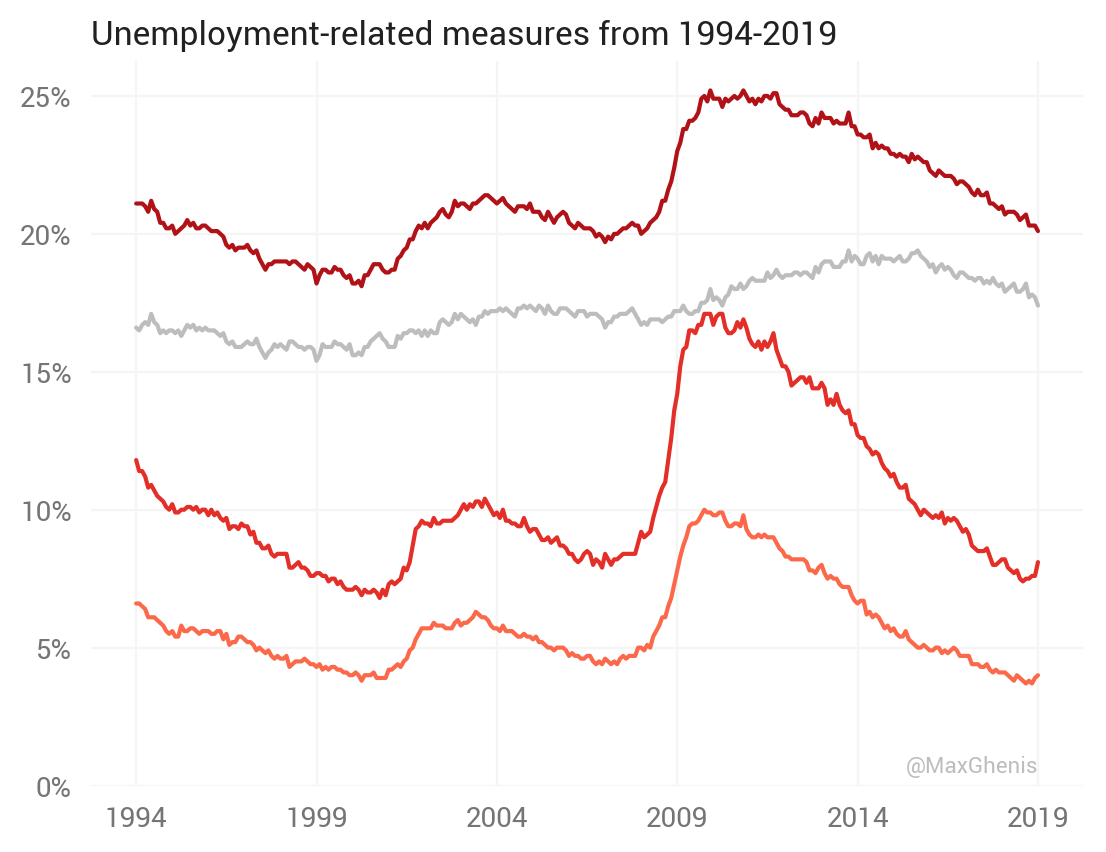

In [ ]:
ax = unemp.drop('pa_lfnpr', axis=1).plot(color=sns.color_palette('Reds', 5)[2:])
unemp.pa_lfnpr.plot(color=PALETTE[False])

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))

ax.set(xlabel='', 
       ylabel='',
       ylim=(0, None))

plt.title('Unemployment-related measures from 1994-2019',
          loc='left')

ax.grid(color='#f5f5f5')

ax.text(unemp.index.max(), 0.5, '@MaxGhenis',
        horizontalalignment='right', size=8, color=PALETTE[False])

sns.despine(left=True, bottom=True)
ax.get_legend().remove()

In [ ]:
years = fred_growth.index.max() - fred_growth.index.min()
avg_growth = (fred_growth.tail(1) + 1) ** (1 / years) - 1
avg_growth

,medpinc,gdppc,life
DATE,,,
2016,0.007473,0.014272,0.001739


In [ ]:
fred_growth.tail(1)

,medpinc,gdppc,life
DATE,,,
2016,0.213572,0.445482,0.046209


In [ ]:
fred.head(1).append(fred.tail(1))

,medpinc,gdppc,life
DATE,,,
1990-01-01,25626.0,37593.0,75.214634
2016-01-01,31099.0,54340.0,78.690244
